# Maximum Likelihood Parameter Estimation

In this first exercise, we would like to use the maximum-likelihood method to estimate the best parameter of a data density model $p(x|\theta)$ with respect to some dataset $\mathcal{D} = (x_1,\dots,x_N)$, and use that approach to build a classifier. Assuming the data is generated independently and identically distributed (iid.), the dataset likelihood is given by
$$
p(\mathcal{D}|\theta) = \prod_{k=1}^N p(x_k|\theta)
$$
and the maximum likelihood solutionss is then computed as
\begin{align*}
\hat{\theta}
&= \text{arg}\max_\theta ~ p(\mathcal{D}|\theta)\\
&= \text{arg}\max_\theta ~ \log p(\mathcal{D}|\theta)
\end{align*}
where the log term can also be expressed as a sum, i.e.
$$
\log p(\mathcal{D}|\theta) = \sum_{k=1}^N \log p(x_k|\theta).
$$
As a first step, we load some useful libraries for numerical computations and plotting.

In [32]:
import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
na = numpy.newaxis

We now consider the univariate data density model 

$$
p(x|\theta) = \frac1\pi \frac{1}{1+(x-\theta)^2}
$$

also known as the Cauchy distribution with fixed parameter $\gamma=1$, and with parameter $\theta$ unknown. Compared to the Gaussian distribution, the Cauchy distribution is heavy-tailed, and this can be useful to handle the presence of outliers in the data generation process. The probability density function is implemented below.

In [33]:
def pdf(X,THETA):
    return (1.0 / numpy.pi) * (1.0 / (1+(X-THETA)**2))

Note that the function can be called with scalars or with numpy arrays, and if feeding arrays of different shape, numpy broadcasting rules will apply. Our first step will be to implement a function that estimates the optimal parameter $\hat{\theta}$ in the maximum likelihood sense for some dataset $\mathcal{D}$.

**Task (10 P):**

* **Implement a function that takes a dataset $\mathcal{D}$ as input (given as one-dimensional array of numbers) and a list of candidate parameters $\theta$ (also given as a one-dimensional array), and returns a one-dimensional array containing the log-likelihood w.r.t. the dataset $\mathcal{D}$ for each parameter $\theta$.**

In [34]:
def ll(D,THETA):
    
    # --------------------------------------
    # TODO: replace by your code 
    # --------------------------------------
    return numpy.log(pdf(D[:, None], THETA[None])).sum(axis=0)
    # --------------------------------------

To test the method, we apply it to some dataset, and plot the log-likelihood for some plausible range of parameters $\theta$.

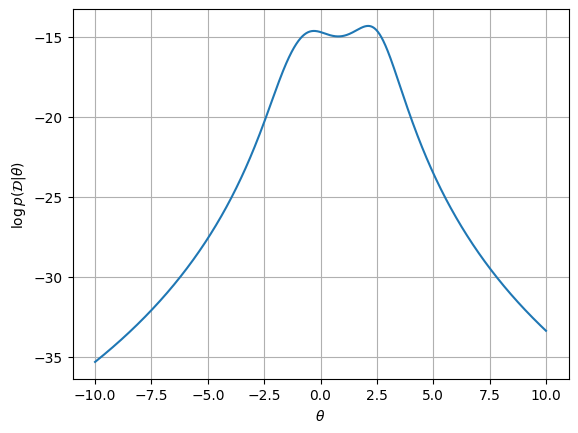

In [35]:
D = numpy.array([ 2.803, -1.563, -0.853,  2.212, -0.334,  2.503])

THETA = numpy.linspace(-10,10,1001)

plt.grid(True)
plt.plot(THETA,ll(D,THETA))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p(\mathcal{D}|\theta)$')
plt.show()

We observe that the likelihood has two peaks: one around $\theta=-0.5$ and one around $\theta=2$. However, the highest peak is the second one, hence, the second peak is retained as a maximum likelihood solution.

### Building a Classifier

We now would like to use the maximum likelihood technique to build a classifier. We consider a labeled dataset where the data associated to the two classes are given by:

In [36]:
D1 = numpy.array([ 2.803, -1.563, -0.853,  2.212, -0.334,  2.503])
D2 = numpy.array([-4.510, -3.316, -3.050, -3.108, -2.315])

To be able to classify new data points, we consider the discriminant function

$$
g(x) = \log P(x|\hat{\theta}_1) -  \log P(x|\hat{\theta}_2) + \log P(\omega_1) - \log P(\omega_2)
$$

were the first two terms can be computed based on our maximum likelihood estimates, and where the last two terms are the prior probabilities. The function $g(x)$ produces the decision $\omega_1$ if $g(x) > 0$ and $\omega_2$ if $g(x) < 0$. We would like to implement a maximum-likelihood based classifier.

**Tasks (10 P):**

* **Implement the function `fit` that receives as input a vector of candidate parameters $\theta$ and the dataset associated to each class, and produces the maximum likelihood parameter estimates.** *(Hint: from your function `fit`, you can call the function `ll` you have previously implemented.)*


* **Implement the function `predict` that takes as input the prior probability for each class and a vector of points X on which to evaluate the discriminant function, and that outputs a vector containing the value of $g$ for each point in X.**

In [37]:
class MLClassifier:
    
    def fit(self,THETA,D1,D2):
        
        # --------------------------------------
        # TODO: replace by your code 
        # --------------------------------------
        self.theta1 = THETA[numpy.argmax(ll(D1, THETA))]
        self.theta2 = THETA[numpy.argmax(ll(D2, THETA))]
        # --------------------------------------
        
    def predict(self,X,p1,p2):
        
        # --------------------------------------
        # TODO: replace by your code 
        # --------------------------------------
        return numpy.log(pdf(X, self.theta1)) - numpy.log(pdf(X, self.theta2)) + numpy.log(p1) - numpy.log(p2)
        # --------------------------------------

Once these two functions have been implemented, the maximum likelihood classifier can be applied to our labeled data, and the decision function it implements can be visualized.

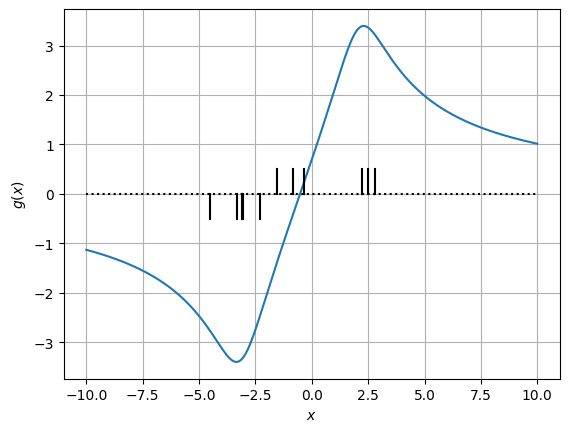

In [38]:
X = numpy.linspace(-10,10,1001)

plt.grid(True)

mlcl = MLClassifier()
mlcl.fit(THETA,D1,D2)

plt.plot(X,mlcl.predict(X,0.5,0.5))
plt.plot(X,0*X,color='black',ls='dotted')

plt.xlabel(r'$x$')
plt.ylabel(r'$g(x)$')

for d1 in D1: plt.plot([d1,d1],[0,+0.5],color='black')
for d2 in D2: plt.plot([d2,d2],[0,-0.5],color='black')

Here, we observe that the model essentially learns a threshold classifier with threshold approximately $-0.5$. However, we note that the threshold seems to be too high to properly classify the data. One reason for this is the fact that maximum likelihood estimate retains only the best parameter. Here, the model for the first class focuses mainly on the peak at $x=2$ and treat examples $x < 0$ as outliers, without considering the possibility that the peak at $\theta=2$ might actually be the outlier.

# Bayes Parameter Estimation

Let us now bypass the computation of a maximum likelihood estimate of parameters and adopt instead a full Bayesian approach. We will consider the same data density model and datasets as in the maximum likelihood exercise but we include now a prior distribution over the parameters. Specifically, we set for both classes the prior distribution:

$$
p(\theta) = \frac{1}{10\pi} \frac{1}{1+(\theta/10)^2}
$$

Given a dataset $\mathcal{D}$, the posterior distribution for the unknown parameter $\theta$ can then be obtained from the Bayes rule:

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D} | \theta)p(\theta)}{\int p(\mathcal{D} | \theta)p(\theta) d\theta}
$$

The integration can be performed numerically using the trapezoidal rule.

**Task (10 P):**

* **Implement the prior and posterior functions below. These function receive as input a vector of parameters $\theta$ (assumed to be sorted from smallest to largest, linearly spaced, and covering the range of values where most of the probability mass lies). The posterior function also receive a dataset $\mathcal{D}$ as input. Both functions return a vector containing the probability scores associated to each value of $\theta$.**

In [39]:
def prior(THETA):

    # --------------------------------------
    # TODO: replace by your code 
    # --------------------------------------
    return (1.0/(10*numpy.pi)) * (1.0/(1.0 + (THETA/10)**2))
    # --------------------------------------

def posterior(D,THETA):
    
    # --------------------------------------
    # TODO: replace by your code 
    # --------------------------------------
    density = pdf(D[:, None], THETA[None]).prod(axis = 0)
    joint = density * prior(THETA)
    integral = (((joint[-1] + joint[1:])/2) * (THETA[1:] - THETA[:-1])).sum()
    return joint/integral
    # --------------------------------------

To verify the implementation of the two functions, we apply them to the dataset $\mathcal{D}$ defined above and with a broad range of parameters $\theta$.

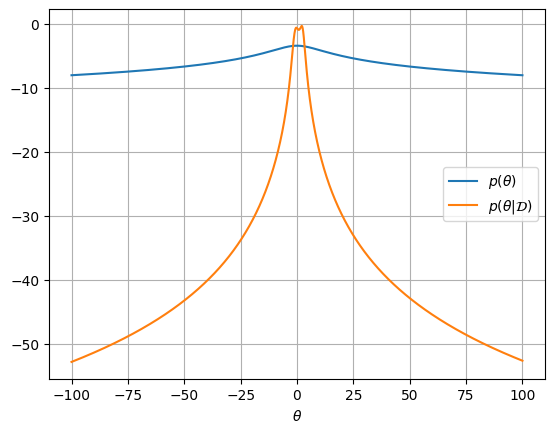

In [40]:
THETA = numpy.linspace(-100,100,10001)

plt.grid(True)
plt.plot(THETA,numpy.log(prior(THETA)),label=r'$p(\theta)$')
plt.plot(THETA,numpy.log(posterior(D,THETA)),label=r'$p(\theta|\mathcal{D})$')
plt.legend(); plt.xlabel(r'$\theta$'); plt.show()

We observe that the posterior distribution is more concentrated to the specific values of the parameter that explain the dataset well. In particular, we observe the same two peaks around $\theta=-0.5$ and $\theta=2$ observed in the maximum likelihood exercise.

### Building a Classifier

We now would like to build a Bayes classifier based on the discriminant function

$$
h(x) = \log P(x|\mathcal{D}_1) -  \log P(x|\mathcal{D}_2) + \log P(\omega_1) - \log P(\omega_2)
$$

where the dataset-conditioned densities are obtained from the original data density model and the parameter posterior as

$$
p(x|\mathcal{D}_j) = \int p(x|\theta) p(\theta|\mathcal{D}_j) d\theta
$$

**Tasks (10 P):**

* **Implement a function `fit` that produces the parameter posteriors $p(\theta|\mathcal{D}_1)$ and $p(\theta|\mathcal{D}_2)$.**
* **Implement a function `predict` computing the new discriminant function $h$ based on the dataset-conditioned data densities.**

In [41]:
class BayesClassifier:
    
    def fit(self,THETA,D1,D2):
        
        # --------------------------------------
        # TODO: replace by your code 
        # --------------------------------------
        self.THETA = THETA
        self.post1 = posterior(D1, THETA)
        self.post2 = posterior(D2, THETA)
        # --------------------------------------
        
    def predict(self,X,p1,p2):
        
        # --------------------------------------
        # TODO: replace by your code 
        # --------------------------------------
        density = pdf(X[:, None], self.THETA[None])
        joint1 = density * self.post1[None]
        joint2 = density * self.post2[None]
        
        PD1 = (((joint1[:,:-1] + joint1[:,1:])/2) * (self.THETA[1:] - self.THETA[:-1])).sum(axis=1)
        PD2 = (((joint2[:,:-1] + joint2[:,1:])/2) * (self.THETA[1:] - self.THETA[:-1])).sum(axis=1)
        
        return numpy.log(PD1) - numpy.log(PD2) + numpy.log(p1) - numpy.log(p2)
        # --------------------------------------

We note that the function `predict` is computationally more expensive than the one for maximum likelihood since it involves computing an integral for each point to be predicted.

However, the quality of the prediction also differs compared to that of the maximum likelihood method. In the plot below, we compare the ML and Bayes approaches.

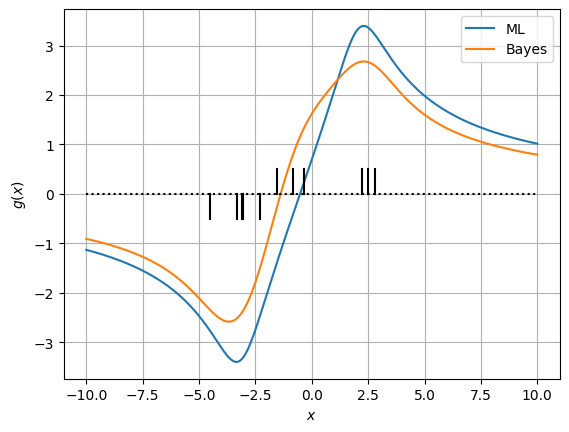

In [42]:
X = numpy.linspace(-10,10,1001)

bacl = BayesClassifier()
bacl.fit(THETA,D1,D2)

plt.grid(True)
plt.plot(X,mlcl.predict(X,0.5,0.5),label='ML')
plt.plot(X,bacl.predict(X,0.5,0.5),label='Bayes')

plt.plot(X,0*X,color='black',ls='dotted')
plt.xlabel(r'$x$'); plt.ylabel(r'$g(x)$')
plt.legend()

for d1 in D1: plt.plot([d1,d1],[0,+0.5],color='black')
for d2 in D2: plt.plot([d2,d2],[0,-0.5],color='black')

We observe that the Bayes classifier has generally lower output scores and its decision boundary has been noticeably shifted to the left, leading to better predictions for the current data. In this particular case, the difference between the two models can be explained by the fact that the Bayes one better integrates the possibility that negative examples for the first class are not necessarily outliers.